# Generate circlized plot for gender only analysis DEG results

In [1]:
library(biomaRt)
library(circlize)
library(tidyverse)
library(ComplexHeatmap)

circlize version 0.4.11
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))


-- Attaching packages --------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0

-- Conflicts ------------------------------------------------------------------------------------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x dplyr::select() masks biomaRt::se

## Prepare data

### Get gene annotation

In [2]:
ensembl = useEnsembl(biomart="ensembl", dataset="hsapiens_gene_ensembl")
biomart = getBM(attributes=c('ensembl_gene_id', 'chromosome_name', 
                         'start_position', 'end_position'),
            mart=ensembl)
biomart %>% head(2)

,ensembl_gene_id,chromosome_name,start_position,end_position
,<chr>,<chr>,<int>,<int>
1,ENSG00000210049,MT,577,647
2,ENSG00000211459,MT,648,1601


### Get logFC for differential expression analysis

In [3]:
extract_bed <- function(fn, biomart){
    bed = data.table::fread(fn) %>%
        select(gencodeID, ensemblID, Symbol, logFC, "adj.P.Val") %>% 
        inner_join(biomart, by=c("ensemblID"="ensembl_gene_id")) %>%
        select(chromosome_name, start_position, end_position, logFC, "adj.P.Val") %>%
        mutate(chromosome_name=paste0('chr', chromosome_name))
    bed_male = bed %>% filter(logFC > 0, adj.P.Val < 0.05)
    bed_female = bed %>% filter(logFC < 0, adj.P.Val < 0.05)
    bed_nonsig = bed %>% filter(adj.P.Val > 0.05)
    return(list("male"=bed_male, "female"=bed_female))
}


In [4]:
cvd = extract_bed("../../_m/genes/diffExpr_CvD_sex_full.txt", biomart)
cvh = extract_bed("../../_m/genes/diffExpr_CvH_sex_full.txt", biomart)
dvh = extract_bed("../../_m/genes/diffExpr_DvH_sex_full.txt", biomart)

## Circos Plot

In [5]:
plot_circos <- function(caudate, dlpfc, hippo){
    lgd_points = Legend(at=c("Caudate", "DLPFC", "Hippocampus"), 
                        type="points", 
                        legend_gp=gpar(col = c("#000080", "#8B0000", "#006400")), 
                        title_position="topleft", title="Brain Region", 
                        background="#FFFFFF")
    circos.clear() # clear plot if there is any
    circos.par("start.degree" = 90) # rotate 90 degrees
    # initialize with ideogram
    # use hg38, default is hg19
    circos.initializeWithIdeogram(species="hg38")
    circos.genomicTrack(caudate, #bg.border="#000080",
                        panel.fun = function(region, value, ...) {
                            i = getI(...)
                            circos.genomicPoints(region, value, pch = 16, 
                                                 cex = 0.6, col = c("#000080", "#8B0000")[i], ...)
    })
    circos.genomicTrack(dlpfc, #bg.border="#8B0000",
                        panel.fun = function(region, value, ...) {
                            i = getI(...)
                            circos.genomicPoints(region, value, pch = 16, 
                                                 cex = 0.6, col = c("#000080", "#006400")[i], ...)
    })
    circos.genomicTrack(hippo, #bg.border="#006400",
                        panel.fun = function(region, value, ...) {
                            i = getI(...)
                            circos.genomicPoints(region, value, pch = 16, 
                                                 cex = 0.6, col = c("#8B0000", "#006400")[i], ...)
    })
    draw(lgd_points, x=unit(5, "mm"), y=unit(5, "mm"), just=c("left", "bottom"))
}


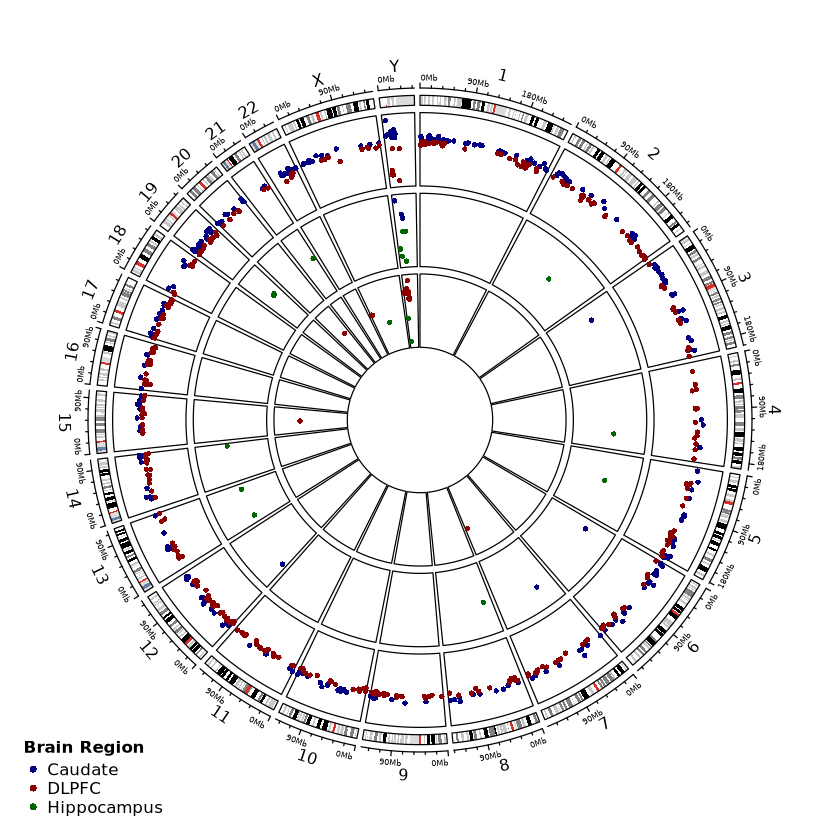

In [6]:
plot_circos(cvd, cvh, dvh)

In [ ]:
png(filename = paste0("significant_circos_plot_brainregions.png"))
plot_circos(cvd, cvh, dvh)
dev.off()

pdf(file = paste0("significant_circos_plot_brainregions.pdf"))
plot_circos(cvd, cvh, dvh)
dev.off()

svg(filename = paste0("significant_circos_plot_brainregions.svg"))
plot_circos(cvd, cvh, dvh)
dev.off()

### Sex differences using all brains

In [7]:
sex = extract_bed("../../_m/genes/diffExpr_sex_full.txt", biomart)

In [8]:
plot_circos_small <- function(bed_list){
    lgd_points = Legend(at=c("Female Bias", "Male Bias"), type="points", 
                        legend_gp=gpar(col = c("red", "blue")), 
                        title_position="topleft", title="Sex Bias", 
                        background="#FFFFFF")
    circos.clear() # clear plot if there is any
    circos.par("start.degree" = 90) # rotate 90 degrees
    # initialize with ideogram
    # use hg38, default is hg19
    circos.initializeWithIdeogram(species="hg38") 
    # add logFC as a genomic track
    circos.genomicTrack(bed_list, track.height=inches_h(1),
                        text(0, 0, "All Brain Regions", cex = 1),
                        panel.fun = function(region, value, ...) {
                            i = getI(...)
                            circos.genomicPoints(region, value, pch = 16, 
                                                 cex = 0.6, col = c("blue", "red")[i], ...)
    })
    draw(lgd_points, x=unit(5, "mm"), y=unit(5, "mm"), just=c("left", "bottom"))
}

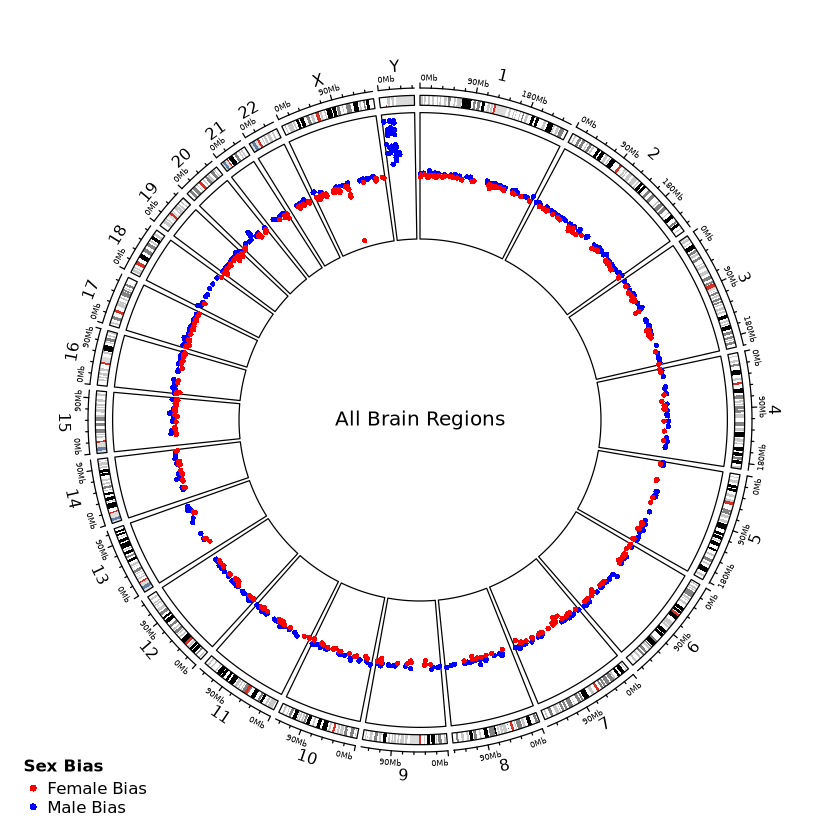

In [9]:
plot_circos_small(sex)

In [ ]:
png(filename = paste0("significant_circos_plot_sex.png"))
plot_circos_small(sex)
dev.off()

pdf(file = paste0("significant_circos_plot_sex.pdf"))
plot_circos_small(sex)
dev.off()

svg(filename = paste0("significant_circos_plot_sex.svg"))
plot_circos_small(sex)
dev.off()